<a href="https://colab.research.google.com/github/evelynhasama/AITDeepLearning/blob/main/Evelyn_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2021 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlretrieve
import numpy as np
import random
import sys
import re, cgi
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [2]:
url_great_gatsby="https://www.gutenberg.org/cache/epub/64317/pg64317.txt"
urlretrieve(url_great_gatsby, 'great_gatsby.txt')
great_gatsby = open("great_gatsby.txt", encoding='utf-8').read().lower()

url_huck_finn="https://www.gutenberg.org/cache/epub/76/pg76.txt"
urlretrieve(url_huck_finn, 'huck_finn.txt')
huck_finn = open("huck_finn.txt", encoding='utf-8').read().lower()

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [4]:
print('Num characters in The Great Gatsby:', len(great_gatsby))
print('Num characters in Adventures of Huckleberry Finn:', len(huck_finn))

Num characters in The Great Gatsby: 289901
Num characters in Adventures of Huckleberry Finn: 590189


<BarContainer object of 2 artists>

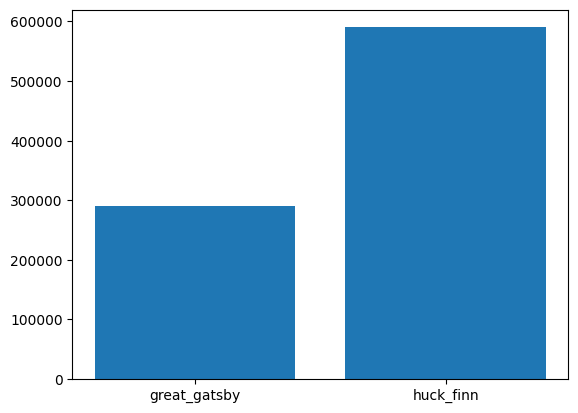

In [7]:
data = {"great_gatsby" : len(great_gatsby), "huck_finn" : len(huck_finn)}
plt.bar(data.keys(), data.values())

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [11]:
gg_chars = sorted(list(set(great_gatsby)))
hf_chars = sorted(list(set(huck_finn)))
print("Unique chars in The Great Gatsby:", len(gg_chars))
print("Unique chars in Adventures of Huckleberry Finn:", len(hf_chars))

Unique chars in The Great Gatsby: 69
Unique chars in Adventures of Huckleberry Finn: 64


In [68]:
all_chars = list(set(hf_chars + gg_chars))
all_char_indices = dict((c, i) for i, c in enumerate(all_chars))
print("Unique chars:", len(all_chars))

print ("Indices to char dictionary:", gg_indices_char)

Unique chars: 72
Indices to char dictionary: {0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '"', 5: '#', 6: '$', 7: '%', 8: "'", 9: '(', 10: ')', 11: '*', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: '[', 30: ']', 31: 'a', 32: 'b', 33: 'c', 34: 'd', 35: 'e', 36: 'f', 37: 'g', 38: 'h', 39: 'i', 40: 'j', 41: 'k', 42: 'l', 43: 'm', 44: 'n', 45: 'o', 46: 'p', 47: 'q', 48: 'r', 49: 's', 50: 't', 51: 'u', 52: 'v', 53: 'w', 54: 'x', 55: 'y', 56: 'z', 57: 'ç', 58: 'é', 59: 'ê', 60: 'ô', 61: '\u200a', 62: '—', 63: '‘', 64: '’', 65: '“', 66: '”', 67: '…', 68: '\ufeff'}


In [69]:
alphabet_length = len(all_char_indices)
print(alphabet_length)

72


In [70]:
sequence_length = 60  
step    = 60 
gg_sentences  = [] 
hf_sentences  = [] 

In [71]:
for i in range(0, len(great_gatsby)-sequence_length, step):
    gg_sentences.append(great_gatsby[i:i+sequence_length])

for i in range(0, len(huck_finn)-sequence_length, step):
    hf_sentences.append(huck_finn[i:i+sequence_length])

In [72]:
print("total num sentences:", (len(hf_sentences)+len(gg_sentences)))

total num sentences: 14667


In [73]:
X = np.zeros((len(hf_sentences)+len(gg_sentences), sequence_length, alphabet_length), dtype =float)
y = np.zeros((len(hf_sentences)+len(gg_sentences),2), dtype=float)

In [74]:
for i, sentence in enumerate(gg_sentences):
    for t, char in enumerate(sentence): 
        X[i,t,all_char_indices[char]] = 1
    y[i][0] = 1

for i, sentence in enumerate(hf_sentences):
    for t, char in enumerate(sentence): 
        X[len(gg_sentences)+i,t,all_char_indices[char]] = 1
    y[len(gg_sentences)+i][1] = 1

print ("Shape of the input data:", X.shape)
print ("Shape of the target data:", y.shape)

Shape of the input data: (14667, 60, 72)
Shape of the target data: (14667, 2)


## Data splitting
Split the data into train, validate and test sets. Make 

In [75]:
# 80% train, 10% validate, 10% test

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=47)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [79]:
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[-2], X.shape[-1]), dropout=0.3))
model.add(Dense(y_train.shape[1]))
model.add(Activation('sigmoid'))

In [80]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                35072     
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
 activation_5 (Activation)   (None, 2)                 0         
                                                                 
Total params: 35,202
Trainable params: 35,202
Non-trainable params: 0
_________________________________________________________________


In [81]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Model training
Train the model and apply early stopping.

In [82]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

In [83]:
model.fit(X_train, y_train, 
          epochs=100, batch_size=32, 
          validation_data=(X_valid,y_valid),
          callbacks=[es],
          verbose=2)

Epoch 1/100
367/367 - 17s - loss: 0.6332 - accuracy: 0.6678 - val_loss: 0.6248 - val_accuracy: 0.6817 - 17s/epoch - 45ms/step
Epoch 2/100
367/367 - 14s - loss: 0.6269 - accuracy: 0.6699 - val_loss: 0.6060 - val_accuracy: 0.6714 - 14s/epoch - 37ms/step
Epoch 3/100
367/367 - 14s - loss: 0.5972 - accuracy: 0.6747 - val_loss: 0.6193 - val_accuracy: 0.6776 - 14s/epoch - 39ms/step
Epoch 4/100
367/367 - 14s - loss: 0.5922 - accuracy: 0.6757 - val_loss: 0.5690 - val_accuracy: 0.7021 - 14s/epoch - 39ms/step
Epoch 5/100
367/367 - 14s - loss: 0.5511 - accuracy: 0.6968 - val_loss: 0.4977 - val_accuracy: 0.7580 - 14s/epoch - 38ms/step
Epoch 6/100
367/367 - 13s - loss: 0.5257 - accuracy: 0.7294 - val_loss: 0.4800 - val_accuracy: 0.7457 - 13s/epoch - 36ms/step
Epoch 7/100
367/367 - 14s - loss: 0.4996 - accuracy: 0.7464 - val_loss: 0.4733 - val_accuracy: 0.7607 - 14s/epoch - 37ms/step
Epoch 8/100
367/367 - 14s - loss: 0.4823 - accuracy: 0.7574 - val_loss: 0.4376 - val_accuracy: 0.7771 - 14s/epoch - 38

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [84]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

46/46 [==============================] - 1s 16ms/step - loss: 0.2962 - accuracy: 0.8691
Test loss: 0.29624953866004944
Test accuracy: 0.8691206574440002


## Confusion matrix
Calculate and display the confusion matrix.

46/46 [==============================] - 1s 13ms/step


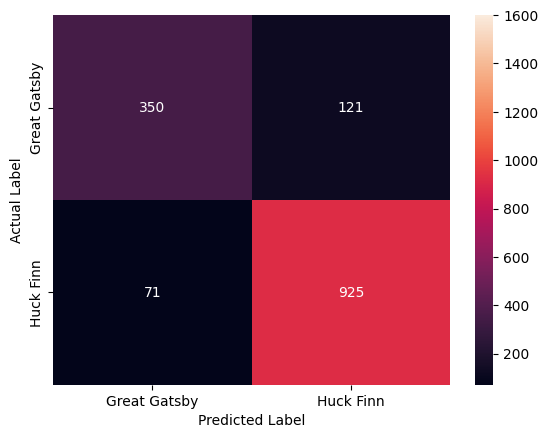

In [85]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

preds = model.predict(X_test)
conf=confusion_matrix(np.argmax(y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=1600, xticklabels=["Great Gatsby", "Huck Finn"], yticklabels=["Great Gatsby", "Huck Finn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()